## This notebook aims to visualize and test the EONIA distribution produced by GAN

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
import scipy.stats as stats


from dotenv.main import load_dotenv
load_dotenv(override=True)

import os

## Note to self -- We only test EONIA

In [2]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('../../../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)
    
    # Select only the third, sixth, and seventh columns

    # 2, 5, 6
    selected_columns = df.iloc[:, [6]]  # Remember: Python uses 0-based indexing

    pre_test_df = selected_columns[selected_columns.index < start_test_date]
    test_df = selected_columns[selected_columns.index >= start_test_date].iloc[:252]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

In [3]:
asset_names = returns_df.columns

## Define a Measure of Success

What constetutes a good generated distribution for EONIA.

This is due to the fact that on Mondays you factor in the weekend.

<Axes: title={'center': 'EONIA Returns for 2006-05'}, xlabel='Date'>

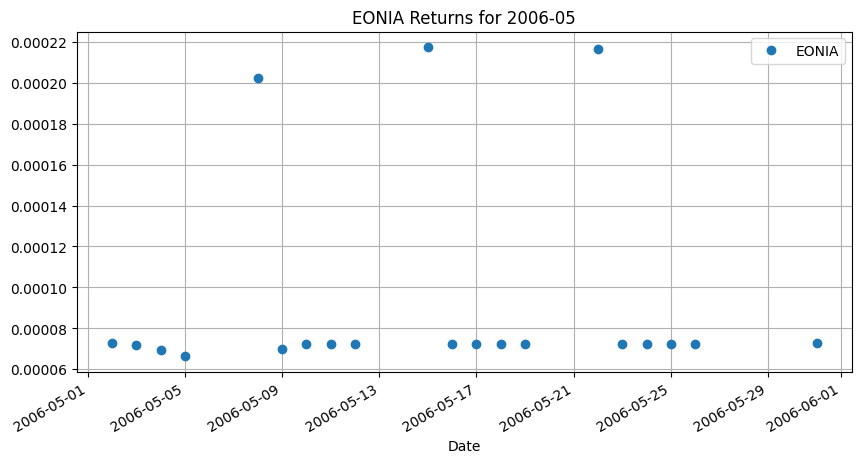

In [4]:
month = '2006-05'  # Change this to the desired year and month (YYYY-MM)
filtered_df = returns_df.loc[month]

# Plot
filtered_df.plot(y='EONIA', marker='o', linestyle='', figsize=(10, 5), grid=True, title=f"EONIA Returns for {month}")



<Axes: xlabel='Date'>

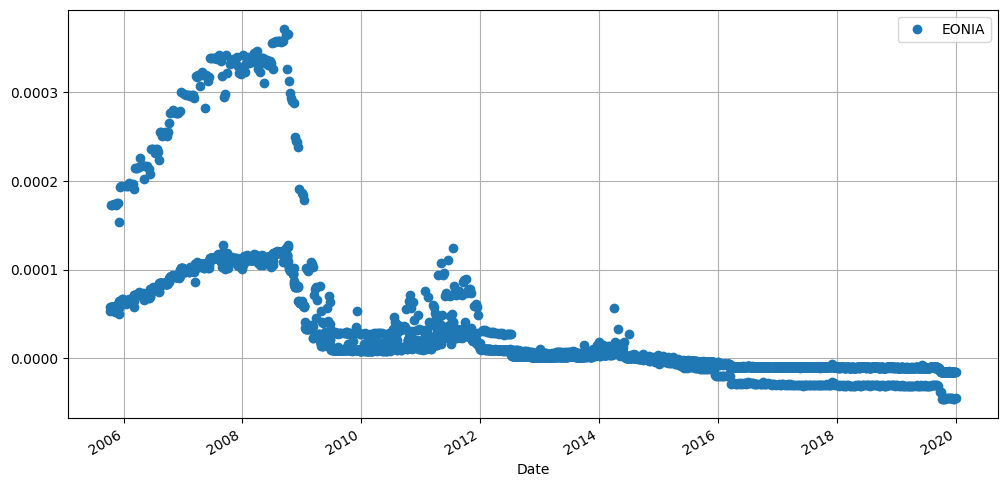

In [5]:
returns_df.plot(y='EONIA', marker='o', linestyle='', figsize=(12,6), grid=True)

In [ ]:
from gan5 import GAN5
from gan6 import GAN6
from gan7 import GAN7
from gan8 import GAN8
from gan9 import GAN9
from gan10 import GAN10


for asset_name in returns_df.columns:
    print(f"Training WGAN for {asset_name}...")
    asset_returns = returns_df[asset_name]
    
    # Create WGAN instance for the current asset
    gan = GAN10(asset_returns, asset_name)
    
    # Train WGAN for this asset
    gan.train()
    
    print(f"Finished training WGAN for {asset_name}.\n")


Training WGAN for EONIA...


In [ ]:
gan.generate_scenarios(num_scenarios=10000)

Generated Returns (first 10 values): [ 4.343754   -1.8372684  -0.11232775 -2.674817    0.0541662  -2.3103027
 -1.1905285   1.1919799  -4.639885    0.9225116 ]
Contains NaN before transformation: False
Generated Returns after Clipping (first 10 values): [ 4.343754   -1.8372684  -0.11232775 -2.674817    0.0541662  -2.3103027
 -1.1905285   1.1919799  -4.639885    0.9225116 ]
Contains NaN after clipping: False
Generated Returns after Inverse Transform (first 10 values): [           nan -3.1025706e-05  1.0114311e-05 -4.4789911e-05
  1.5698502e-05 -3.9122613e-05 -1.8219689e-05  7.3680421e-05
 -6.9388414e-05  5.5129171e-05]
Contains NaN after inverse transform: True
Generated Returns (first 10 values): [ 4.3939633 -1.7561219 -0.1892628 -2.8952303  0.2668873 -2.155828
 -1.1745857  1.114896  -4.801918   1.0300293]
Contains NaN before transformation: False
Generated Returns after Clipping (first 10 values): [ 4.3939633 -1.7561219 -0.1892628 -2.8952303  0.2668873 -2.155828
 -1.1745857  1.114896  

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA
from scipy import stats

def create_rolling_empirical(returns_df, window_size=252):
    """Creates rolling 1-year (252-day) sequences from empirical data"""
    rolling_data = np.array([
        returns_df[i : i + window_size] for i in range(len(returns_df) - window_size)
    ])
    return rolling_data

def check_mode_collapse(real_returns, generated_returns):
    """
    Checks for mode collapse using:
    1. Variance comparison.
    2. Sample diversity (pairwise distance).
    3. PCA visualization (handling NaN issues).
    """

    real_var = np.nanvar(real_returns, axis=0).mean()  # Handle NaNs
    gen_var = np.nanvar(generated_returns, axis=0).mean()

    print(f"Variance of Real Data: {real_var:.6f}")
    print(f"Variance of Generated Data: {gen_var:.6f}")

    if gen_var < 0.5 * real_var:
        print("⚠️ Warning: Possible Mode Collapse - Low Variance in Generated Data")
    else:
        print("✅ Generated Data Shows Reasonable Variance")

    # Check for diversity using pairwise distances
    real_distances = pdist(real_returns, metric="euclidean")
    gen_distances = pdist(generated_returns, metric="euclidean")

    real_mean_dist = np.nanmean(real_distances)
    gen_mean_dist = np.nanmean(gen_distances)

    print(f"Mean Pairwise Distance (Real): {real_mean_dist:.6f}")
    print(f"Mean Pairwise Distance (Generated): {gen_mean_dist:.6f}")

    if gen_mean_dist < 0.5 * real_mean_dist:
        print("⚠️ Warning: Potential Mode Collapse - Samples are too similar")
    else:
        print("✅ Generated samples are reasonably diverse")

    # -------- Fix NaN issue before PCA -------- #
    real_returns = np.nan_to_num(real_returns, nan=np.nanmedian(real_returns))
    generated_returns = np.nan_to_num(generated_returns, nan=np.nanmedian(generated_returns))

    # PCA Projection for real vs generated data
    pca = PCA(n_components=2)
    real_pca = pca.fit_transform(real_returns)
    gen_pca = pca.transform(generated_returns)

    plt.figure(figsize=(8, 6))
    plt.scatter(real_pca[:, 0], real_pca[:, 1], color="blue", label="Real Returns", alpha=0.5)
    plt.scatter(gen_pca[:, 0], gen_pca[:, 1], color="red", label="Generated Returns", alpha=0.5)
    plt.legend()
    plt.title("PCA Projection of Real vs Generated Returns")
    plt.show()


# ---------- PLOTTING FUNCTION ---------- #
def plot_distributions_with_mode_collapse_check(returns_df, precomputed_rolling_returns):
    asset_names = returns_df.columns

    plt.figure(figsize=(12, 6))

    for asset_name in asset_names:
        # Load the generated returns
        gen_returns = torch.load(f'generated_returns_{asset_name}/final_scenarios.pt')
        gen_returns = gen_returns.view(gen_returns.size(0), 252).cpu().detach().numpy()

        empirical_returns = precomputed_rolling_returns[asset_name]

        # KDE Plot
        sns.kdeplot(empirical_returns.flatten(), label=f"{asset_name} - Empirical", linestyle="dashed", linewidth=2)
        sns.kdeplot(gen_returns.flatten(), label=f"{asset_name} - Generated", linewidth=2)

        # Check for mode collapse using **252-day sequences**
        check_mode_collapse(empirical_returns, gen_returns)

    plt.title('Distribution of Returns for All Assets', fontsize=16)
    plt.xlabel('Return', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend(title='Assets', fontsize=12)
    plt.grid(True)
    plt.show()

# ---------- HISTOGRAM PLOT FUNCTION ---------- #

def plot_histogram_distributions(returns_df, precomputed_rolling_returns, bins=500):
    asset_names = returns_df.columns

    plt.figure(figsize=(10, 6))

    for asset_name in asset_names:
        # Load the generated returns
        gen_returns = torch.load(f'generated_returns_{asset_name}/final_scenarios.pt').cpu().detach().numpy()

        # Ensure no NaNs in generated returns
        if np.isnan(gen_returns).any() or np.isinf(gen_returns).any():
            print(f"⚠️ Warning: NaNs or Infs detected in generated returns for {asset_name}. Fixing...")
            gen_returns = np.nan_to_num(gen_returns, nan=np.nanmedian(returns_df[asset_name].values), posinf=1e-6, neginf=-1e-6)

        # Retrieve precomputed empirical returns
        empirical_returns = precomputed_rolling_returns[asset_name]

        # Ensure both have the same length by truncating
        min_length = min(len(empirical_returns.flatten()), len(gen_returns.flatten()))
        real_data = empirical_returns.flatten()[:min_length]
        generated_data = gen_returns.flatten()[:min_length]

        # Avoid precision issues by scaling returns
        scaling_factor = 1e6  
        real_data_scaled = real_data * scaling_factor
        generated_data_scaled = generated_data * scaling_factor

        # Ensure no NaNs after scaling
        real_data_scaled = np.nan_to_num(real_data_scaled, nan=np.nanmedian(real_data_scaled))
        generated_data_scaled = np.nan_to_num(generated_data_scaled, nan=np.nanmedian(generated_data_scaled))

        # Compute statistics safely
        def safe_stat(func, data, default=0):
            try:
                result = func(data)
                return result if np.isfinite(result) else default
            except Exception:
                return default
        
        stats_real = {
            "Mean": safe_stat(np.mean, real_data_scaled),
            "Std Dev": safe_stat(np.std, real_data_scaled),
            "Skewness": safe_stat(stats.skew, real_data_scaled),
            "Kurtosis": safe_stat(stats.kurtosis, real_data_scaled),
            "99.5% VaR": safe_stat(lambda x: np.percentile(x, 0.5), real_data_scaled)
        }

        stats_generated = {
            "Mean": safe_stat(np.mean, generated_data_scaled),
            "Std Dev": safe_stat(np.std, generated_data_scaled),
            "Skewness": safe_stat(stats.skew, generated_data_scaled),
            "Kurtosis": safe_stat(stats.kurtosis, generated_data_scaled),
            "99.5% VaR": safe_stat(lambda x: np.percentile(x, 0.5), generated_data_scaled)
        }

        print(f"\nStatistical Summary for {asset_name} - Real Data:")
        for k, v in stats_real.items():
            print(f"{k}: {v:.6f}")

        print(f"\nStatistical Summary for {asset_name} - Generated Data:")
        for k, v in stats_generated.items():
            print(f"{k}: {v:.6f}")

        # Create Histogram instead of KDE
        plt.hist(real_data_scaled, bins=bins, alpha=0.6, color='blue', label=f"{asset_name} - Real", density=True)
        plt.hist(generated_data_scaled, bins=bins, alpha=0.6, color='red', label=f"{asset_name} - Generated", density=True)

        plt.title(f'Distribution of Returns for {asset_name}', fontsize=14)
        plt.xlabel('Return (Scaled) 10^6', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.show()


# ---------- EXTREME VALUE PLOT FUNCTION ---------- #
def extreme_value_analysis(returns_df, precomputed_rolling_returns):
    asset_names = returns_df.columns
    
    for asset_name in asset_names:
        # Load generated returns
        gen_returns = torch.load(f'generated_returns_{asset_name}/final_scenarios.pt')
        gen_returns = gen_returns.view(gen_returns.size(0), 252).cpu().detach().numpy().flatten()
        
        # Get real returns from precomputed data
        real_returns = precomputed_rolling_returns[asset_name].flatten()
        
        # ---- Tail Histogram (Log-Log Scale) ----
        plt.figure(figsize=(8, 5))
        plt.hist(abs(real_returns), bins=100, alpha=0.6, label=f'{asset_name} - Real', density=True, log=True)
        plt.hist(abs(gen_returns), bins=100, alpha=0.6, label=f'{asset_name} - Generated', density=True, log=True)
        plt.xlabel('Absolute Return (log scale)')
        plt.ylabel('Frequency (log scale)')
        plt.title(f'Tail Histogram (Log-Log) for {asset_name}')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # ---- Tail Quantile Plot ----
        quantiles = np.linspace(0.01, 0.99, 50)
        real_quantiles = np.quantile(real_returns, quantiles)
        gen_quantiles = np.quantile(gen_returns, quantiles)
        
        plt.figure(figsize=(8, 5))
        plt.plot(quantiles, real_quantiles, label='Real Returns', marker='o', linestyle='dashed')
        plt.plot(quantiles, gen_quantiles, label='Generated Returns', marker='s', linestyle='dashed')
        plt.xlabel('Quantile')
        plt.ylabel('Return')
        plt.title(f'Tail Quantile Plot for {asset_name}')
        plt.legend()
        plt.grid(True)
        plt.show()


⚠️ Warning: NaNs or Infs detected in generated returns for EONIA. Fixing...

Statistical Summary for EONIA - Real Data:
Mean: 31.610527
Std Dev: 69.283806
Skewness: 2.682698
Kurtosis: 8.158064
99.5% VaR: -30.750000

Statistical Summary for EONIA - Generated Data:
Mean: -8.537907
Std Dev: 68.996788
Skewness: 1.375614
Kurtosis: 5.709558
99.5% VaR: -188.234818


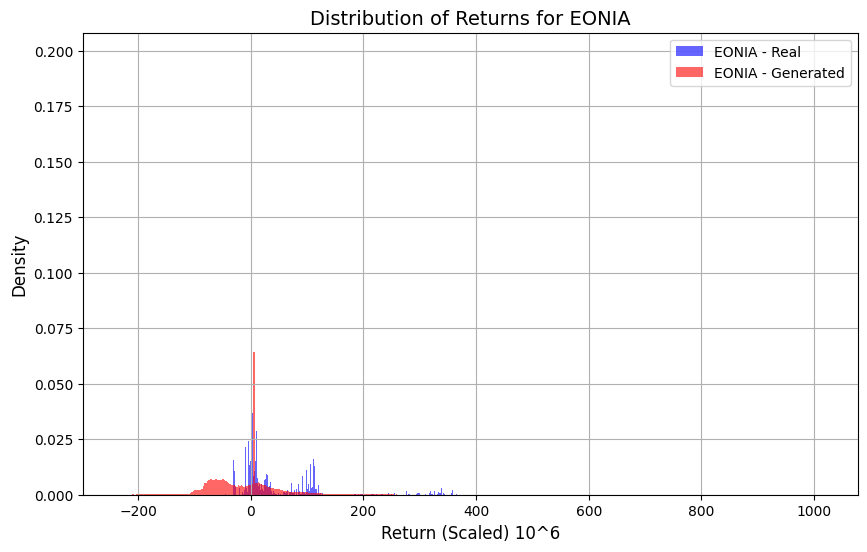

Variance of Real Data: 0.000000
Variance of Generated Data: 0.000000
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.001171
Mean Pairwise Distance (Generated): nan
✅ Generated samples are reasonably diverse


C:\Users\nicka\AppData\Local\Temp\ipykernel_17144\3665352069.py:40: RuntimeWarning: Mean of empty slice
  gen_mean_dist = np.nanmean(gen_distances)


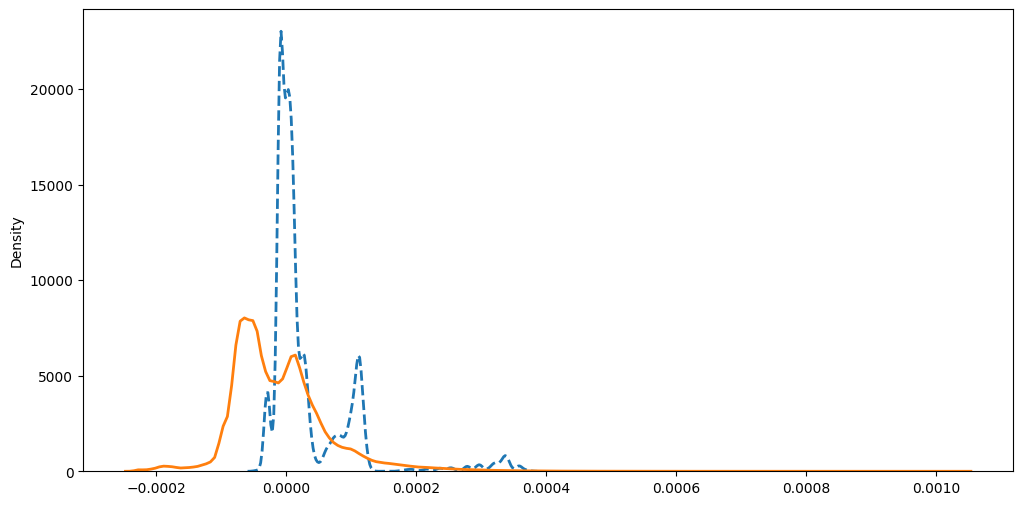

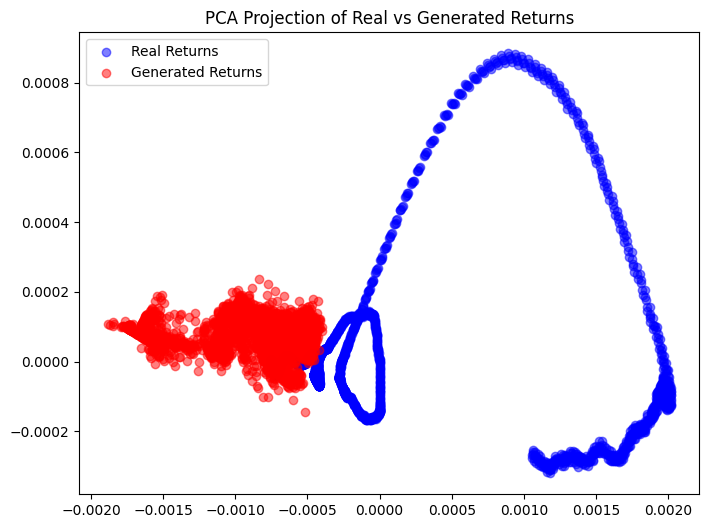

C:\Users\nicka\AppData\Local\Temp\ipykernel_17144\3665352069.py:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Assets', fontsize=12)


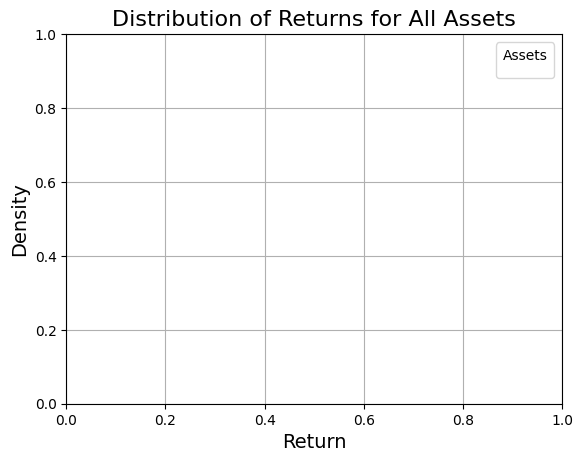

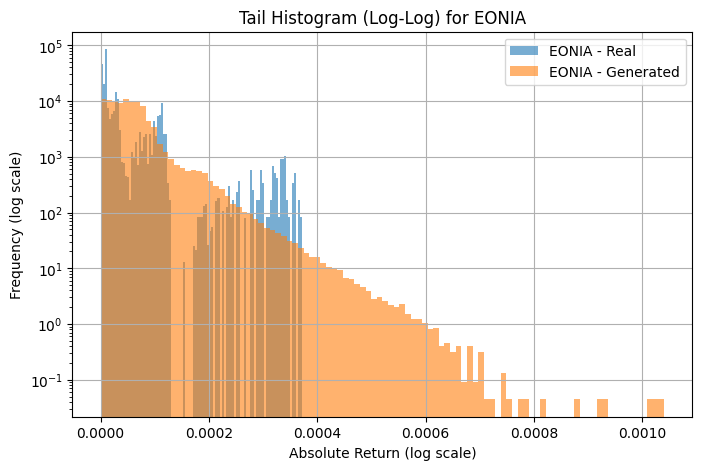

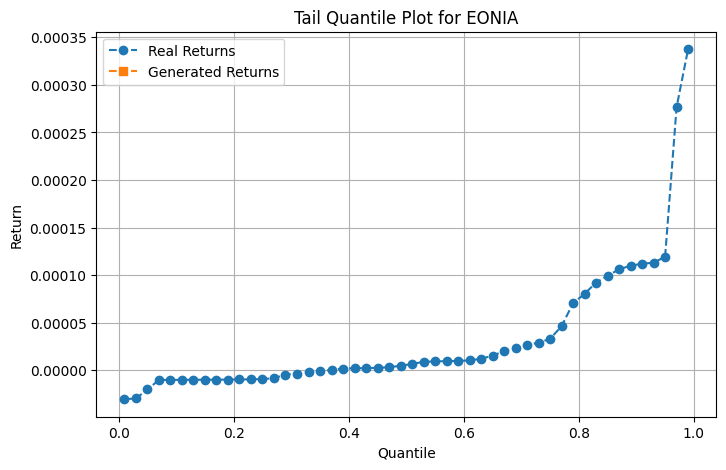

In [ ]:
precomputed_rolling_returns = {asset: create_rolling_empirical(returns_df[asset].values) for asset in returns_df.columns}

# Call functions using precomputed returns
plot_histogram_distributions(returns_df, precomputed_rolling_returns)
plot_distributions_with_mode_collapse_check(returns_df, precomputed_rolling_returns)
extreme_value_analysis(returns_df, precomputed_rolling_returns)